# MIPS   

# Dependency

In [ ]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# np.random.seed(1025)

In [ ]:
class Presenter:
    def __init__(self):
        pass

    def plot(self, x, y, bdy =1, r=1,**kwargs):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        # Now, we draw our points with a gradient of colors.
        ax.scatter(x, y, linewidths=0.5,
                   marker='o', s=1e1*r, facecolors='none', edgecolors='teal',cmap=plt.cm.jet)
        ax.axis('equal')
        ax.set_xlim(-1*bdy, bdy)
        ax.set_ylim(-1*bdy, bdy)
        # ax.set_axis_off()
        plt.show()

In [ ]:
def FJPotential(x, y, d, r6=1e-3, epsilon=1e-3, **kwargs):
    t = np.sqrt(x**2 + y**2)
    rx = x/t
    ry = y/t
    s = epsilon * r6 * (d ** 6 - 2 * r6) / d ** 13
    return s*rx, s*ry


def generate_points_with_min_distance(n, shape, min_dist):
  """
      n: number of points
      example:
      generate_points_with_min_distance(n=100, shape=(100,100), min_dist=0.1)
  """
  # compute grid shape based on number of points
  width_ratio = shape[1] / shape[0]
  num_y = np.int32(np.sqrt(n / width_ratio)) + 1
  num_x = np.int32(n / num_y) + 1

  # create regularly spaced neurons
  x = np.linspace(0., shape[1]-1, num_x, dtype=np.float32)
  y = np.linspace(0., shape[0]-1, num_y, dtype=np.float32)
  coords = np.stack(np.meshgrid(x, y), -1).reshape(-1,2)

  # compute spacing
  init_dist = np.min((x[1]-x[0], y[1]-y[0]))

  # perturb points
  max_movement = (init_dist - min_dist)/2
  noise = np.random.uniform(low=-max_movement,
                              high=max_movement,
                              size=(len(coords), 2))
  coords += noise

  return coords

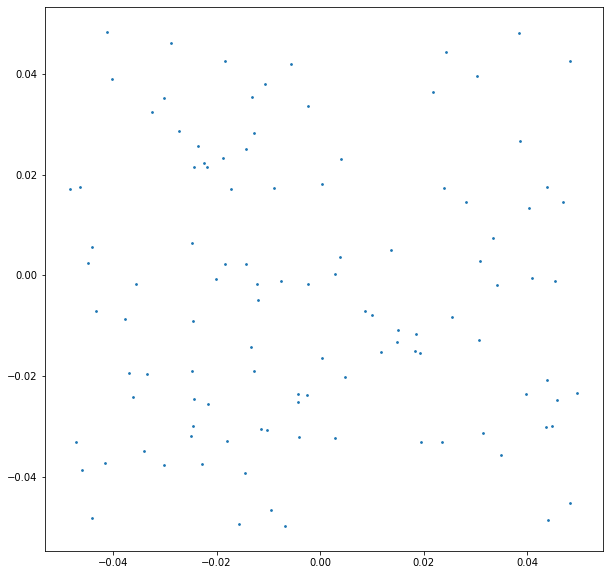

In [ ]:
coords = generate_points_with_min_distance(n=100, shape=(1,1), min_dist=0.1)
plt.figure(figsize=(10,10))
plt.scatter(coords[:,0], coords[:,1], s=3)
plt.show()

# Game

In [ ]:
class Game:
    def __init__(self, updater, presenter, **kwargs):
        """
        posx, posy: (N,) ndarray, position
        theta: (N,) ndarray, [0,1] represent [0, 2pi], the angle that the particle toward
        :param updater:
        :param presenter:
        :param kwargs:
        """
        self.updater = updater
        self.presenter = presenter
        self.p = kwargs

        self.posx = np.array([])
        self.posy = np.array([])
        self.theta = np.array([])

        self.vecx = np.array([])
        self.vecy = np.array([])

        self.set_up(**kwargs)

    def set_up(self, N=100, bdy=1,**kwargs):
        self.posx = np.random.uniform(-1*bdy,bdy,N)
        self.posy = np.random.uniform(-1*bdy,bdy,N)
        
        self.theta = np.random.randn(N)
        self.velocity_reset(**self.p)

    def velocity_reset(self,N=100, **kwargs):
        self.vecx = np.zeros(N)
        self.vecy = np.zeros(N)

    def pos_updater(self, gamma=1, step=1e-3, **kwargs):
        self.posx += step * self.vecx / gamma
        self.posy += step * self.vecy / gamma
        self.diffusion(**self.p)

    def vec_updater(self, N=100, r=1, gamma=1, v_p=1, D=1, **kwargs):
        for i in range(N):
            # interaction
            for j in range(i + 1, N):
                # check if two particles are contacted, mostly are not contact
                self.interaction(i, j, **kwargs)

            # self mobility
            self.motion(i)

    def interaction(self, i, j, **kwargs):
        if -1 * r < self.posx[i] - self.posx[j] < r:
            if -1 * r < self.posy[i] - self.posy[j] < r:
                x_diff = self.posx[i] - self.posx[j]
                y_diff = self.posy[i] - self.posy[j]
                d2 = x_diff ** 2 + y_diff ** 2
                if d2 < kwargs['r2']:
                    # if contact add the repulsive force
                    vpx, vpy = FJPotential(x_diff, y_diff, np.sqrt(d2), **kwargs)
                    self.vecx[i] += vpx
                    self.vecy[i] += vpy
                    self.vecx[j] -= vpx
                    self.vecy[j] -= vpy

    def motion(self, i, v_p=1,**kwargs):
        self.vecx[i] += v_p * np.cos(self.theta[i])
        self.vecy[i] += v_p * np.sin(self.theta[i])


    def diffusion(self,N=100,D_r=1,D_t=1, step=1e-3, **kwargs):
        self.theta += np.sqrt(2*D_r*step)*np.random.randn(N)
        self.posx += np.sqrt(2*D_t*step)*np.random.randn(N)
        self.posy += np.sqrt(2*D_t*step)*np.random.randn(N)

    def run(self, **kwargs):
        self.vec_updater(**self.p)
        self.pos_updater(**self.p)
        self.velocity_reset(**self.p)

    def display(self):
        self.presenter.plot(self.posx,self.posy, **self.p)
        # self.presenter.plot(self.posx, self.posy)
        pass

# RUN

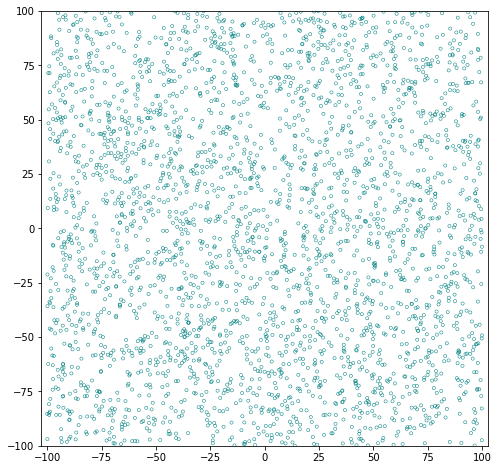

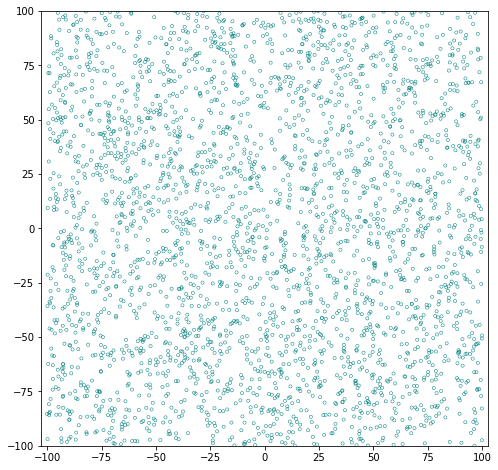

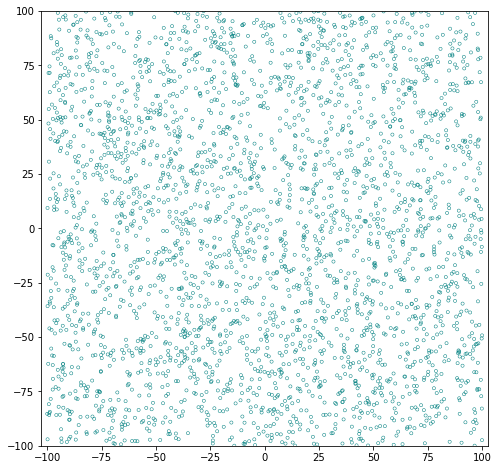

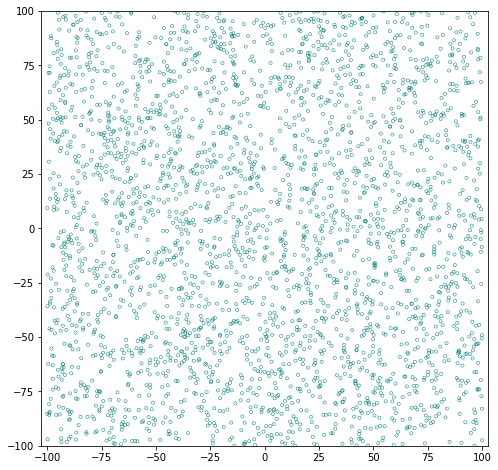

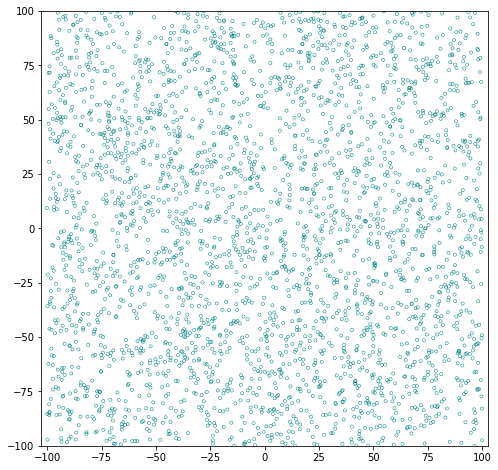

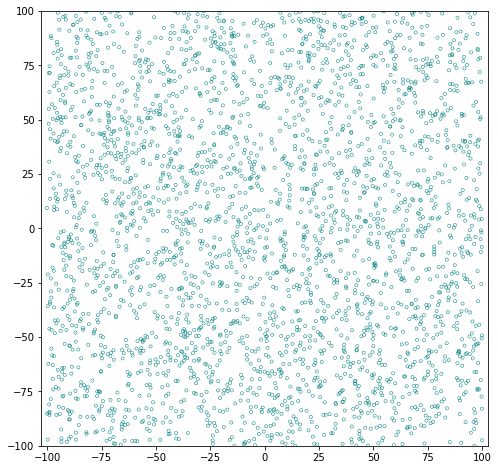

In [ ]:
r = 1e0
r2 = r ** 2
r6 = r ** 6

hyperparameter = {
    'N': 3000,  # number of particles
    'bdy':100,
    'step': 1e-3,
    'epoch': 10,
    'r': r,
    'r2': r2,
    'r6': r6,  # radius of particle power 6
    'gamma': 1,  # fraction
    'epsilon': 1e-10,  # potential depth times 4
    'v_p': 100,  # mean speed
    'D_t': 1,  # transition diffusion
    'D_r': 1,  # rotation diffusion
}

P = Presenter()
game = Game(None, P, **hyperparameter)
game.display()
for _ in range(1):
    game.run()
    game.display()

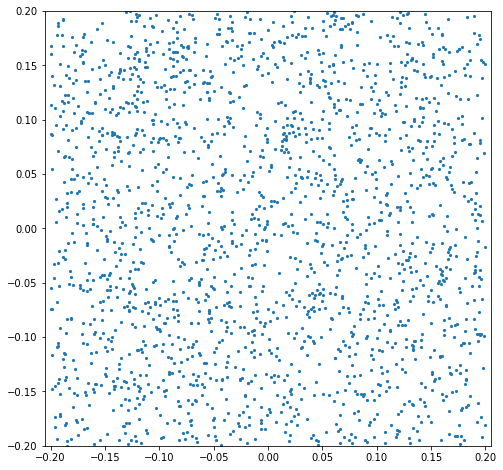

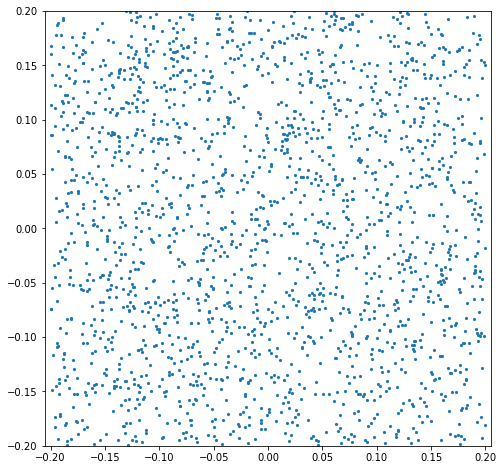

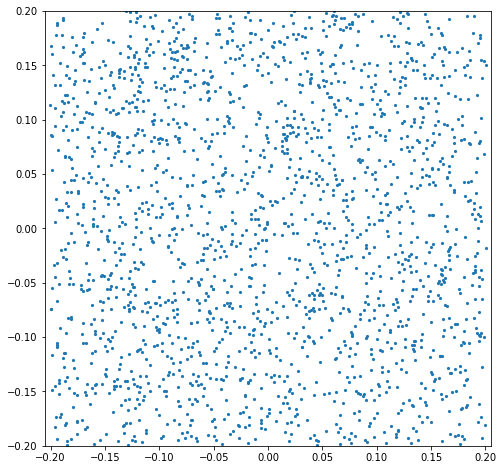

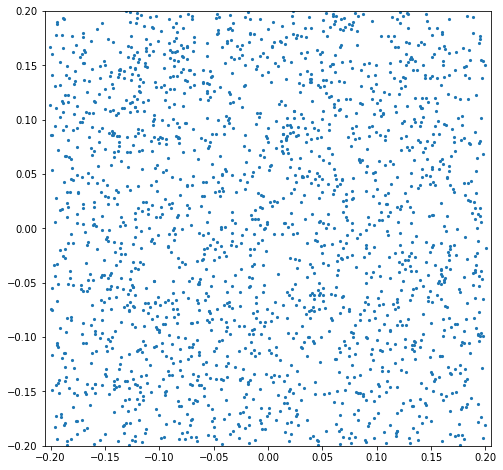

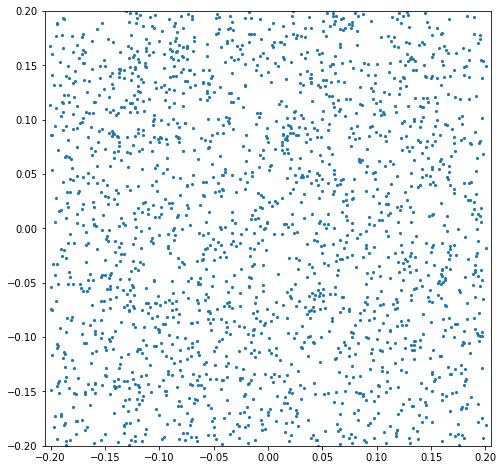

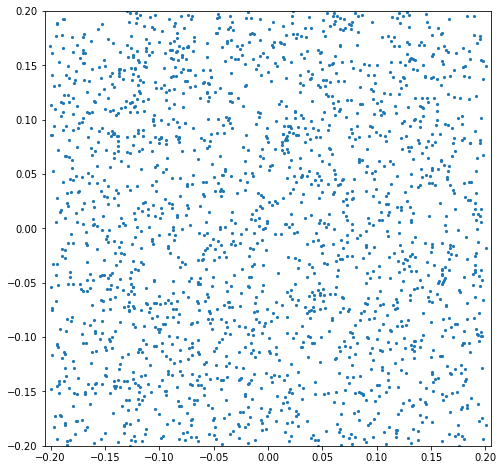

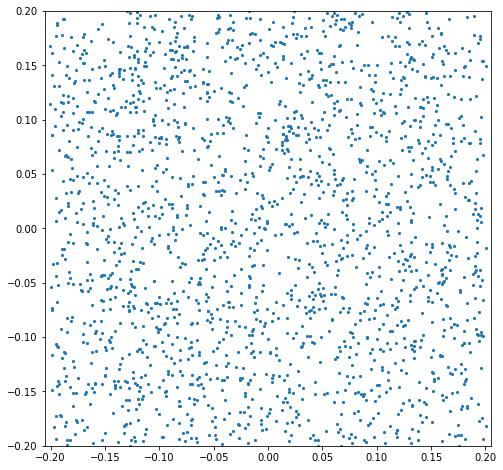

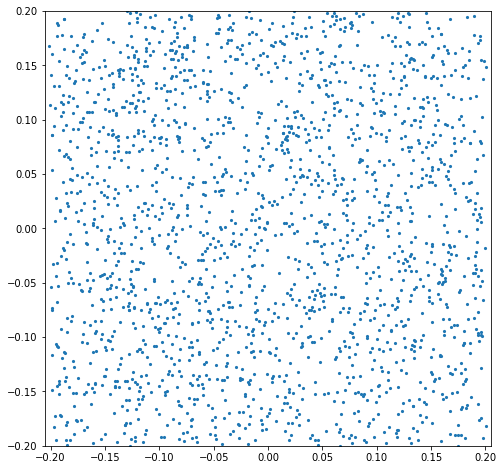

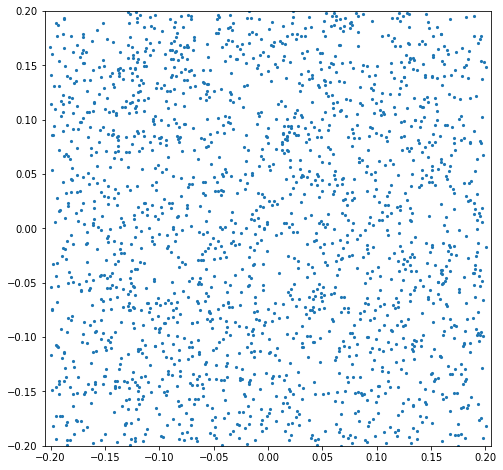

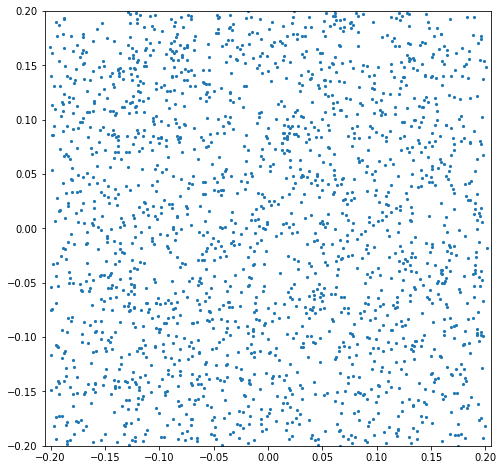

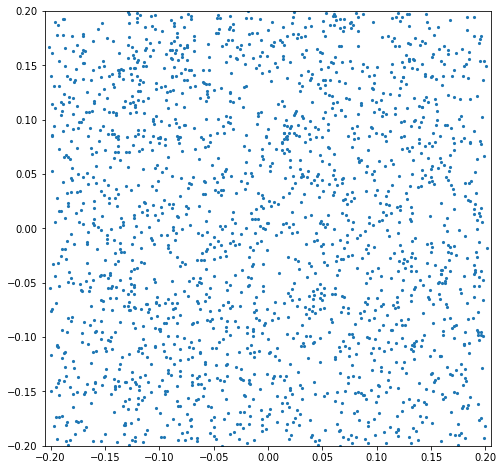

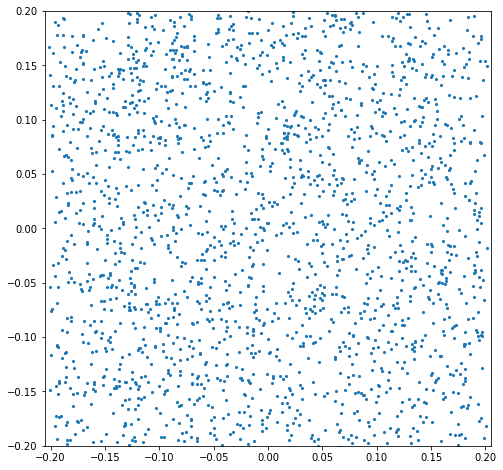

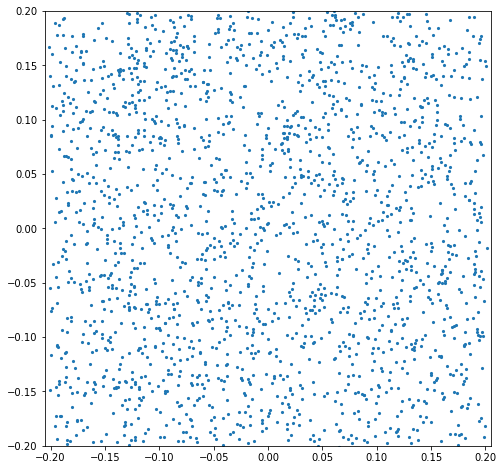

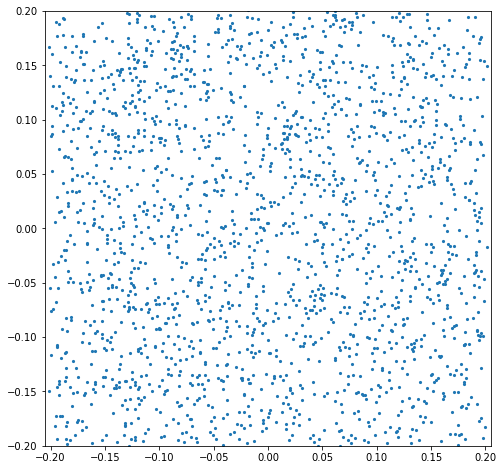

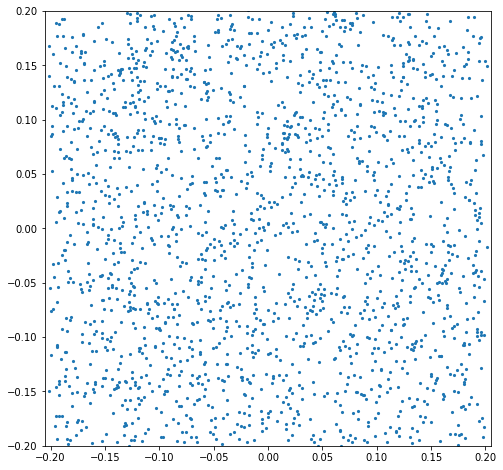

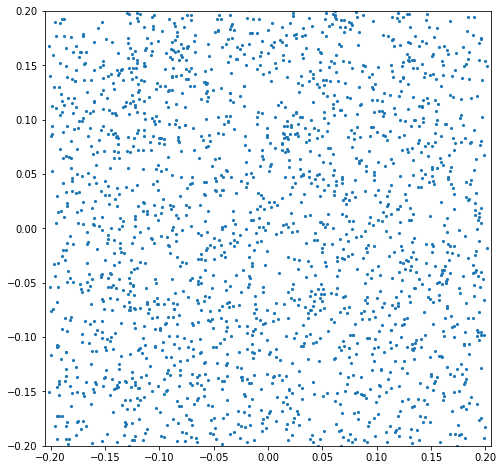

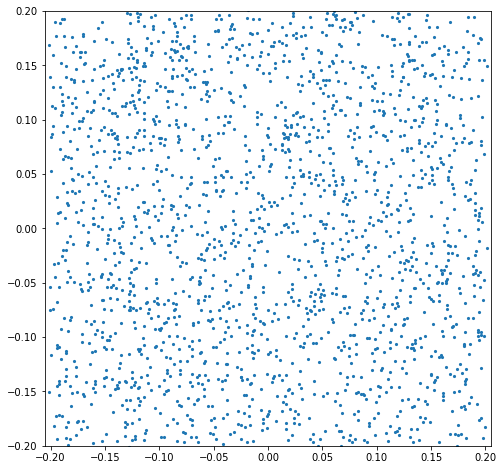

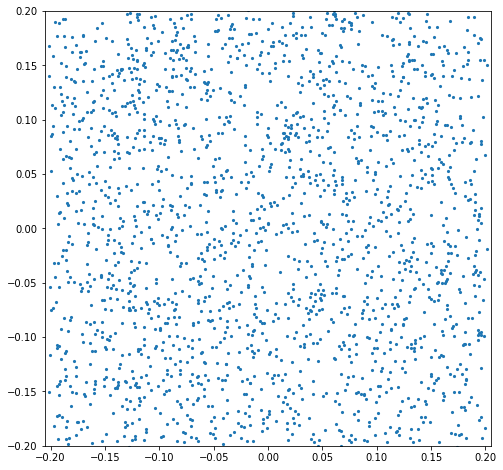

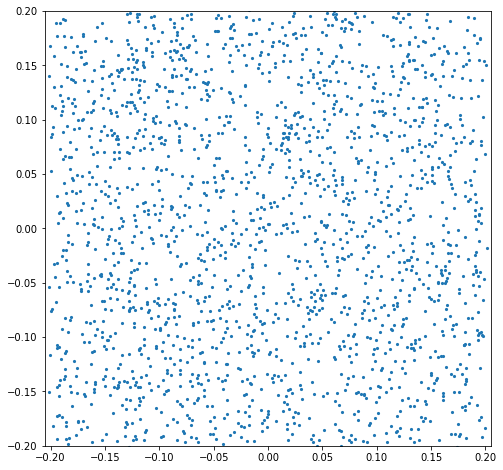

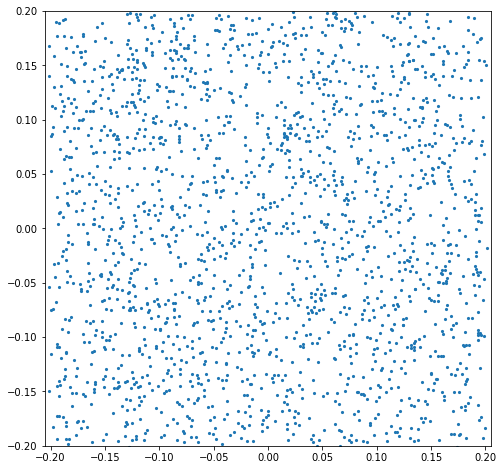

In [ ]:
r = 1e-3
r2 = r ** 2
r6 = r ** 6

hyperparameter = {
    'N': 2000,  # number of particles
    'bdy': 0.2,
    'step': 1e-6,
    'epoch': 10,
    'r': r,
    'r2': r2,
    'r6': r6,  # radius of particle power 6
    'gamma': 1,  # fraction
    'epsilon': 1e-15,  # potential depth times 4
    'v_p': 1,  # mean speed
    'D_t': 1e-2,  # transition diffusion
    'D_r': 1e-2,  # rotation diffusion
}

P = Presenter()
game = Game(None, P, **hyperparameter)
for _ in range(100):
    game.run()
    if _ % 5 ==0:
      game.display()